In [170]:
from google.colab import drive

import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import re

In [171]:
drive.mount('/content/drive')

matches = '/content/drive/My Drive/Colab Notebooks/Datos/WorldCupMatches.csv'
players = '/content/drive/My Drive/Colab Notebooks/Datos/WorldCupPlayers.csv'

matches_df = pd.read_csv(matches)
players_df = pd.read_csv(players)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [172]:
#df_matches = pd.read_csv('WorldCupMatches.csv')
#df_players = pd.read_csv('WorldCupPlayers.csv')

In [173]:
#kinda preprocesing
matches_df.dropna(inplace = True, how='all')
matches_df.drop_duplicates(inplace = True)
matches_df['Year'] = matches_df['Year'].apply(int)
players_df.drop_duplicates(inplace = True)

In [174]:
def unify_germany(team_name):
    return 'Germany' if 'german' in team_name.lower() else team_name

matches_df['Home Team Name'] = matches_df['Home Team Name'].apply(unify_germany)
matches_df['Away Team Name'] = matches_df['Away Team Name'].apply(unify_germany)

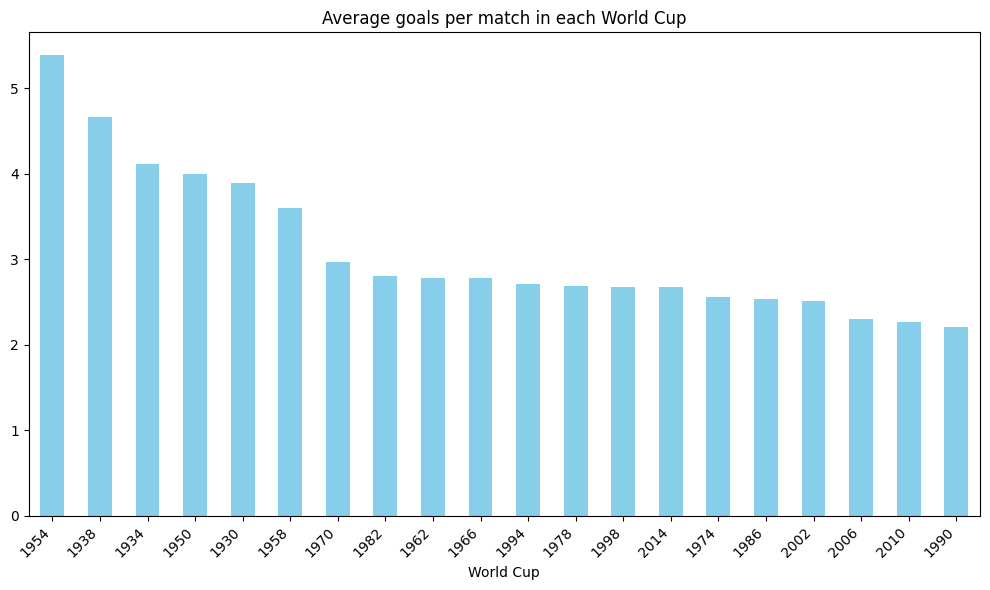

In [175]:
#lets see the average goals per match in each world cup
goals_stats = matches_df.groupby('Year').agg({
    'Home Team Goals': 'sum',
    'Away Team Goals': 'sum',
    'Datetime': 'count'
})

goals_stats['Average goals per match'] = (
    goals_stats['Home Team Goals'] + goals_stats['Away Team Goals']
    ) / goals_stats['Datetime']

goals_stats = goals_stats.sort_values('Average goals per match', ascending=False)

plt.figure(figsize=(10, 6))
goals_stats['Average goals per match'].plot(kind='bar', color='skyblue')
plt.title('Average goals per match in each World Cup')
plt.xlabel('World Cup')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [176]:
#adding 2 more columns for a better analysis
def determine_winner(row):
    if row['Home Team Goals'] > row['Away Team Goals']:
        return row['Home Team Name']
    elif row['Home Team Goals'] < row['Away Team Goals']:
        return row['Away Team Name']
    else:
        if row['Home Team Name'] in row['Win conditions']:
            return row['Home Team Name']
        elif row['Away Team Name'] in row['Win conditions']:
            return row['Away Team Name']

        #completing missing data in penalties win conditions
        elif 'penalties' in row['Win conditions']:
            home, away  = re.findall(r'\b\d+\b', row['Win conditions'])
            return row['Home Team Name'] if home > away else row['Away Team Name']
        else:
            return 'Tie'

def determine_method(row):
    win_condition = row['Win conditions'].lower()

    if 'penalties' in win_condition:
        return 'Penalties'
    elif 'extra time' in win_condition:
        return 'Extra Time'
    elif 'golden goal' in win_condition:
        return 'Golden Goal'
    else:
        return 'Regular Time'

matches_df['Winner'] = matches_df.apply(determine_winner, axis=1)
matches_df['Method'] = matches_df.apply(determine_method, axis=1)

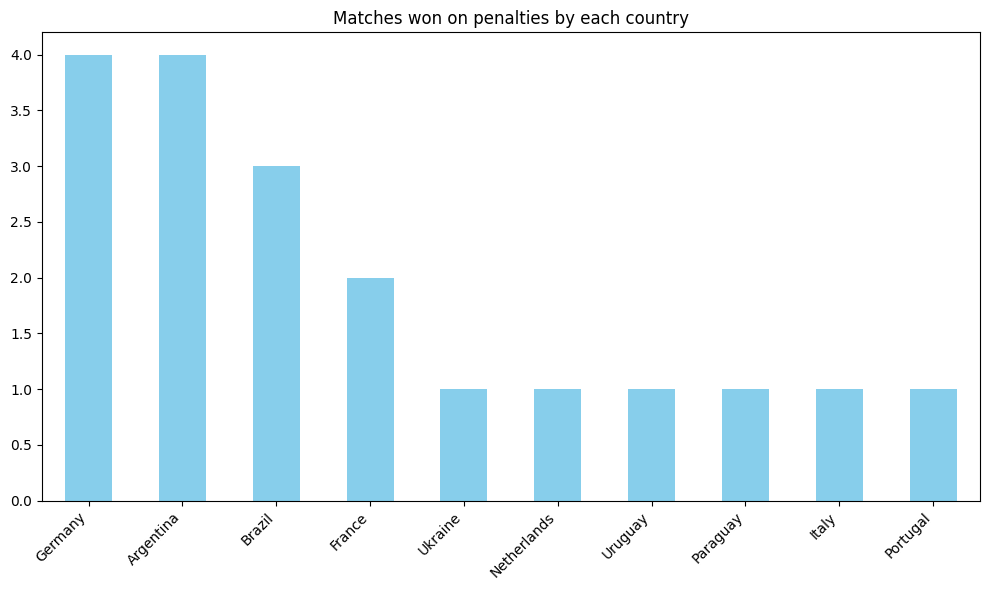

In [177]:
#now lets see countrys which have won most by penalties
penalty_df = matches_df[matches_df['Method'] == 'Penalties']

plt.figure(figsize=(10, 6))
penalty_df['Winner'].value_counts().head(10).plot(kind='bar', color='skyblue')
plt.title('Matches won on penalties by each country')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [178]:
#lets see who was the goalkeeper who saved most their country on penalties
goalkeepers_df = players_df[(players_df['Position'] == 'GK')]

penalty_savers = pd.merge(penalty_df, goalkeepers_df, on = 'MatchID')['Player Name']
print(penalty_savers.value_counts().head(10))

Harald SCHUMACHER    2
KRUL                 2
TAFFAREL             2
CASILLAS             2
CILLESSEN            2
Gianluca PAGLIUCA    2
Sergio GOYCOCHEA     2
VORM                 2
NAVAS K.             2
PEMBERTON P.         2
Name: Player Name, dtype: int64


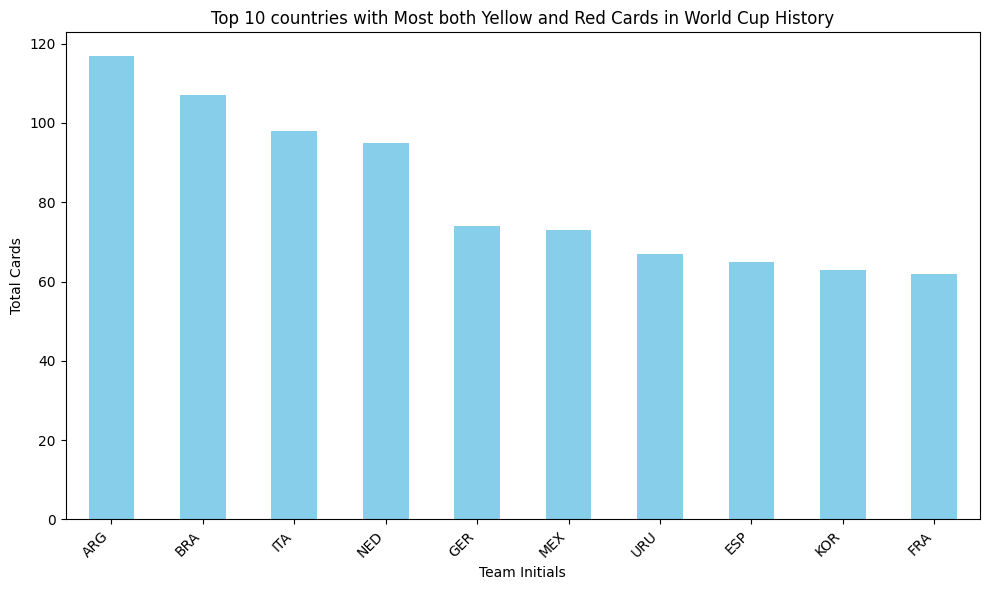

In [191]:
card_events = players_df[players_df['Event'].str.contains('Y|R') & players_df['Event'].notnull()]

card_counts = card_events.groupby('Team Initials')['Event'].value_counts().unstack()
card_counts = card_counts.sum(axis = 1)

plt.figure(figsize=(10, 6))
card_counts.sort_values(ascending=False).head(10).plot(kind='bar', stacked=True, color=['skyblue'])
plt.title('Top 10 countries with Most both Yellow and Red Cards in World Cup History')
plt.ylabel('Total Cards')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [179]:
#goals dataframe creation
goal_events = players_df[players_df['Event'].str.contains(r'[GPW]\d+') & players_df['Event'].notnull()].copy()

def goals_only(text):
    return ' '.join(re.findall(r'[GPW]\d+\'', text))

def determine_goal_type(event):
    if event.startswith('G'):
        return 'Open-play'
    elif event.startswith('P'):
        return 'Penalty'
    elif event.startswith('W'):
        return 'Own Goal'
    else:
        return 'Unknown'

goal_events['Event'] = goal_events['Event'].apply(goals_only)
goal_events['Goal Type'] = goal_events['Event'].apply(determine_goal_type)

split_goals = goal_events['Event'].str.split().explode()

goals_df = pd.DataFrame({
    'MatchID': goal_events.loc[split_goals.index, 'MatchID'].values,
    'RoundID': goal_events.loc[split_goals.index, 'RoundID'].values,
    'Team Initials': goal_events.loc[split_goals.index, 'Team Initials'].values,
    'Line-up': goal_events.loc[split_goals.index, 'Line-up'].values,
    'Player Name': goal_events.loc[split_goals.index, 'Player Name'].values,
    'Goal Minute': split_goals.str.extract(r'([GPW]\d+)')[0],
    'Goal Type': goal_events.loc[split_goals.index, 'Goal Type'].values

}).reset_index(drop=True)

goals_df['Goal Minute'] = pd.to_numeric(goals_df['Goal Minute'].str[1:])

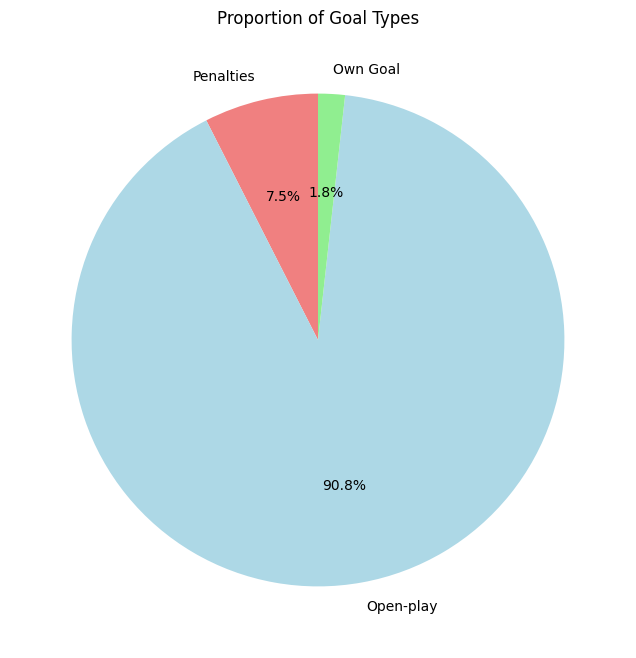

In [195]:
sizes = [
    len(goals_df[(goals_df['Goal Type'] == 'Penalty')]),
    len(goals_df[(goals_df['Goal Type'] == 'Open-play')]),
    len(goals_df[(goals_df['Goal Type'] == 'Own Goal')])
    ]
plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=['Penalties', 'Open-play', 'Own Goal'], colors=['lightcoral', 'lightblue', 'lightgreen'], autopct='%1.1f%%', startangle=90)
plt.title('Proportion of Goal Types')
plt.show()


In [180]:
#lets see how goals are distributed during the matches
'''
minutes_bins = range(0, 93, 4)
plt.figure(figsize=(10, 6))
plt.hist(goals_df['Goal Minute'], bins=minutes_bins, color='skyblue', edgecolor='white')
plt.title('Distribution of Goals Throughout the Match')
plt.xlabel('Minutes')
plt.ylabel('Goals')
plt.xticks(minutes_bins,rotation=45, ha='right')
plt.tight_layout()
plt.show()
'''

"\nminutes_bins = range(0, 93, 4)\nplt.figure(figsize=(10, 6))\nplt.hist(goals_df['Goal Minute'], bins=minutes_bins, color='skyblue', edgecolor='white')\nplt.title('Distribution of Goals Throughout the Match')\nplt.xlabel('Minutes')\nplt.ylabel('Goals')\nplt.xticks(minutes_bins,rotation=45, ha='right')\nplt.tight_layout()\nplt.show()\n"

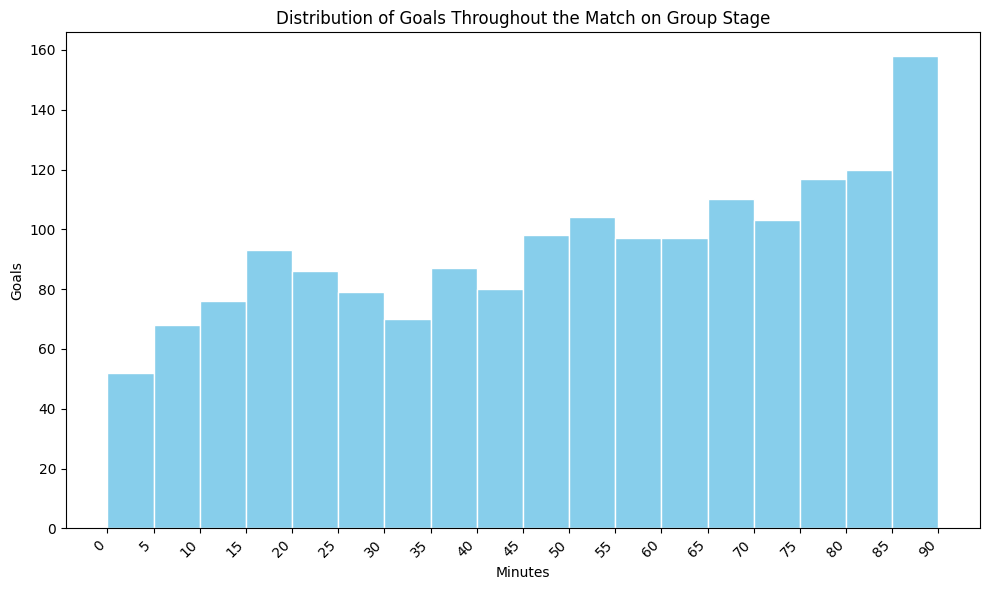

In [181]:
#lets check group goals only
goals_group_stage = pd.merge(goals_df, matches_df[(matches_df['Stage'].str.contains('Group'))][['Stage','MatchID']], on= 'MatchID',how = 'inner')

minutes_bins = range(0, 91, 5)
plt.figure(figsize=(10, 6))
plt.hist(goals_group_stage['Goal Minute'], bins=minutes_bins, color='skyblue', edgecolor='white')
plt.title('Distribution of Goals Throughout the Match on Group Stage')
plt.xlabel('Minutes')
plt.ylabel('Goals')
plt.xticks(minutes_bins, rotation=45, ha='right')
plt.tight_layout()
plt.show()

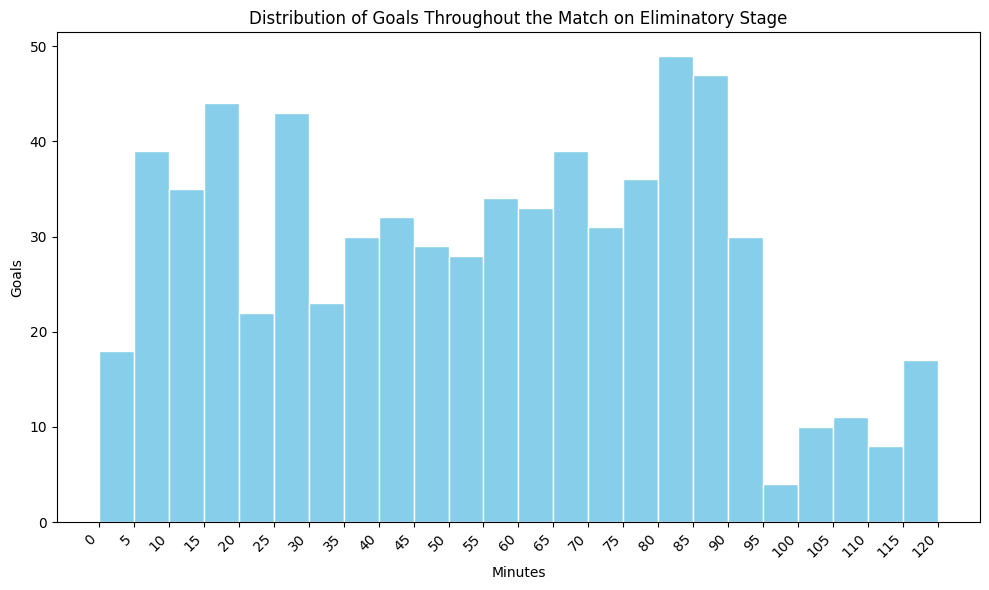

In [182]:
#eliminatory stage goals now
goals_eliminatory_stage = pd.merge(goals_df, matches_df[~(matches_df['Stage'].str.contains('Group'))][['Stage','MatchID']], on= 'MatchID',how = 'inner')

minutes_bins = range(0, 121, 5)
plt.figure(figsize=(10, 6))
plt.hist(goals_eliminatory_stage['Goal Minute'], bins=minutes_bins, color='skyblue', edgecolor='white')
plt.title('Distribution of Goals Throughout the Match on Eliminatory Stage')
plt.xlabel('Minutes')
plt.ylabel('Goals')
plt.xticks(minutes_bins, rotation=45, ha='right')
plt.tight_layout()
plt.show()

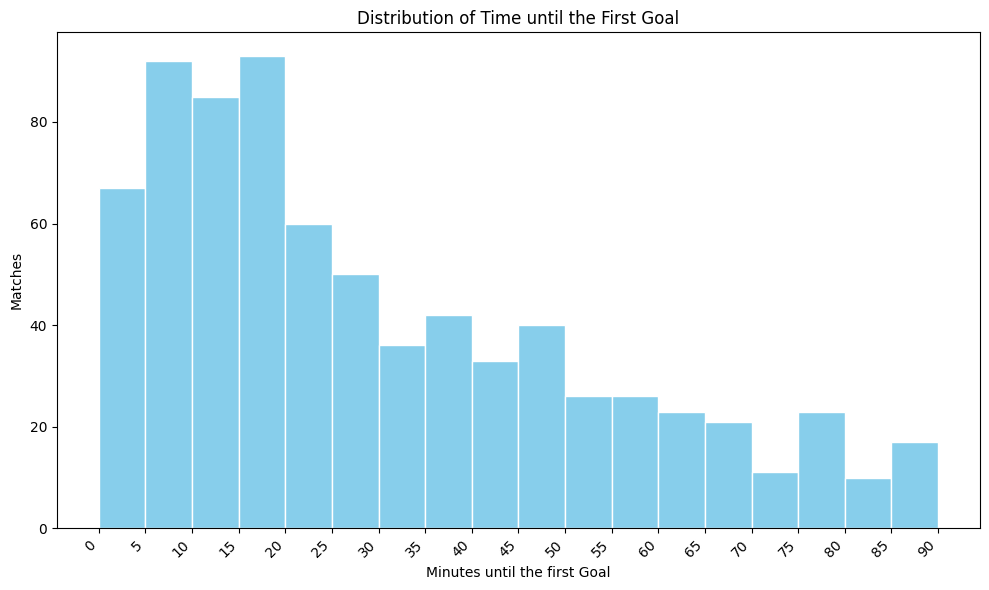

In [183]:
#lets see the distribution of time until the first goal, of course only on matches with at least one goal
first_goal_time = goals_df.groupby('MatchID')['Goal Minute'].min().reset_index()

minutes_bins = range(0, 91, 5)
plt.figure(figsize=(10, 6))
plt.hist(first_goal_time['Goal Minute'], bins=minutes_bins, color='skyblue', edgecolor='white')
plt.title('Distribution of Time until the First Goal')
plt.xlabel('Minutes until the first Goal')
plt.ylabel('Matches')
plt.xticks(minutes_bins, rotation=45, ha='right')
plt.tight_layout()
plt.show()

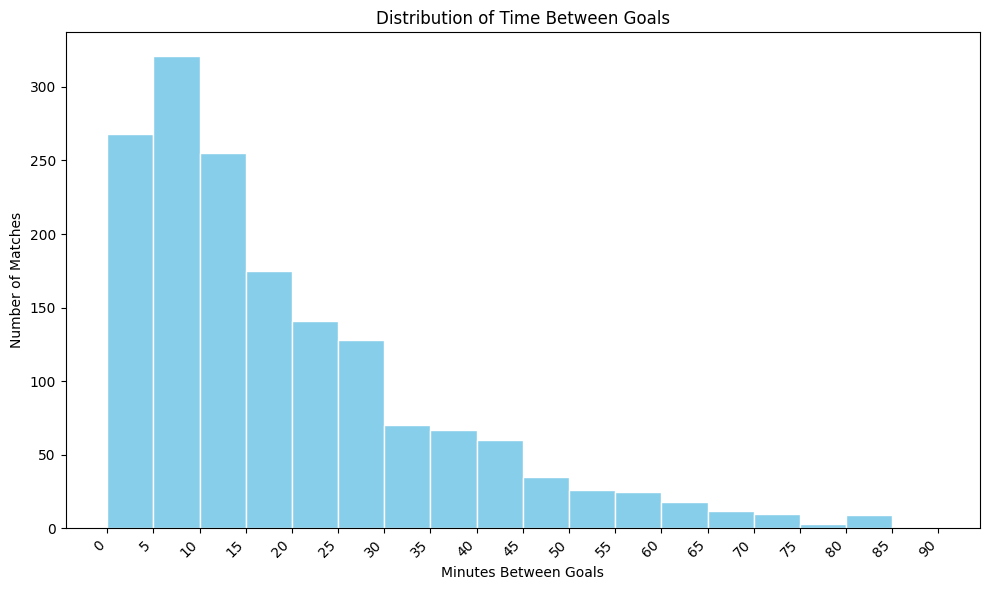

In [184]:
#now lets check the distribution of time between goals on matches with more than one goal
time_between_goals = goals_df.sort_values(['MatchID', 'Goal Minute'])

time_between_goals['Time Between Goals'] = time_between_goals.groupby('MatchID')['Goal Minute'].diff()
time_between_goals.dropna(subset=['Time Between Goals'], inplace = True)

minutes_bins = range(0, 91, 5)
plt.figure(figsize=(10, 6))
plt.hist(time_between_goals['Time Between Goals'], bins=minutes_bins, color='skyblue', edgecolor='white')
plt.title('Distribution of Time Between Goals')
plt.xlabel('Minutes Between Goals')
plt.ylabel('Number of Matches')
plt.xticks(minutes_bins,rotation=45, ha='right')
plt.tight_layout()
plt.show()


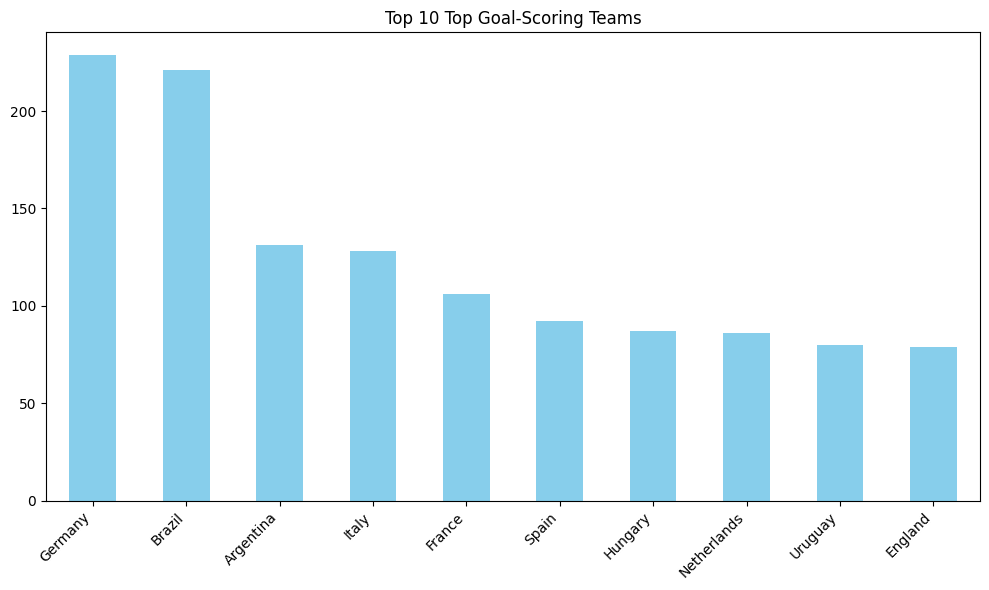

In [197]:
goals_per_team = (matches_df.groupby('Home Team Name')['Home Team Goals'].sum() +
                  matches_df.groupby('Away Team Name')['Away Team Goals'].sum())

plt.figure(figsize=(10, 6))
goals_per_team.sort_values(ascending=False).head(10).plot(kind='bar', color='skyblue')
plt.title('Top 10 Top Goal-Scoring Teams')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

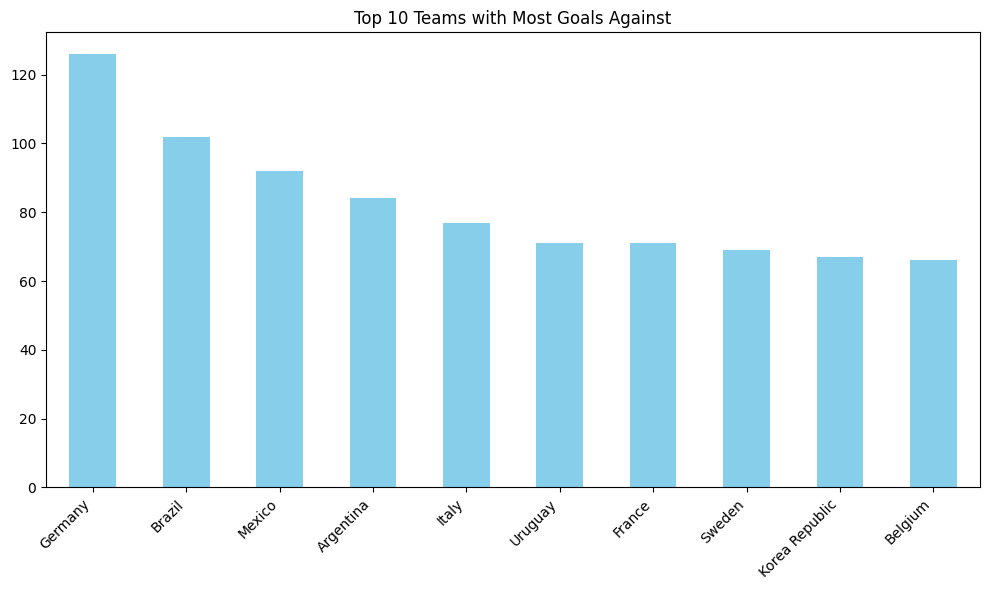

In [196]:
goals_against_per_team = (matches_df.groupby('Away Team Name')['Home Team Goals'].sum() +
                          matches_df.groupby('Home Team Name')['Away Team Goals'].sum())

plt.figure(figsize=(10, 6))
goals_against_per_team.sort_values(ascending=False).head(10).plot(kind='bar', color='skyblue')
plt.title('Top 10 Teams with Most Goals Against')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

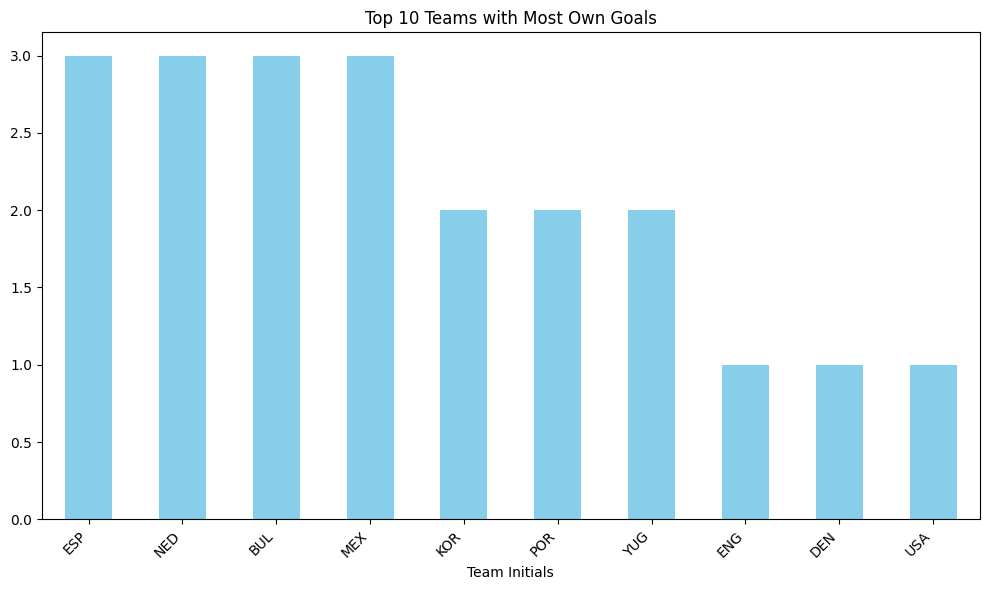

In [198]:
own_goals = goals_df[(goals_df['Goal Type'] == 'Own Goal')]
own_goals_teams = own_goals.groupby('Team Initials')['Goal Type'].count()

plt.figure(figsize=(10, 6))
own_goals_teams.sort_values(ascending=False).head(10).plot(kind='bar', color='skyblue')
plt.title('Top 10 Teams with Most Own Goals')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


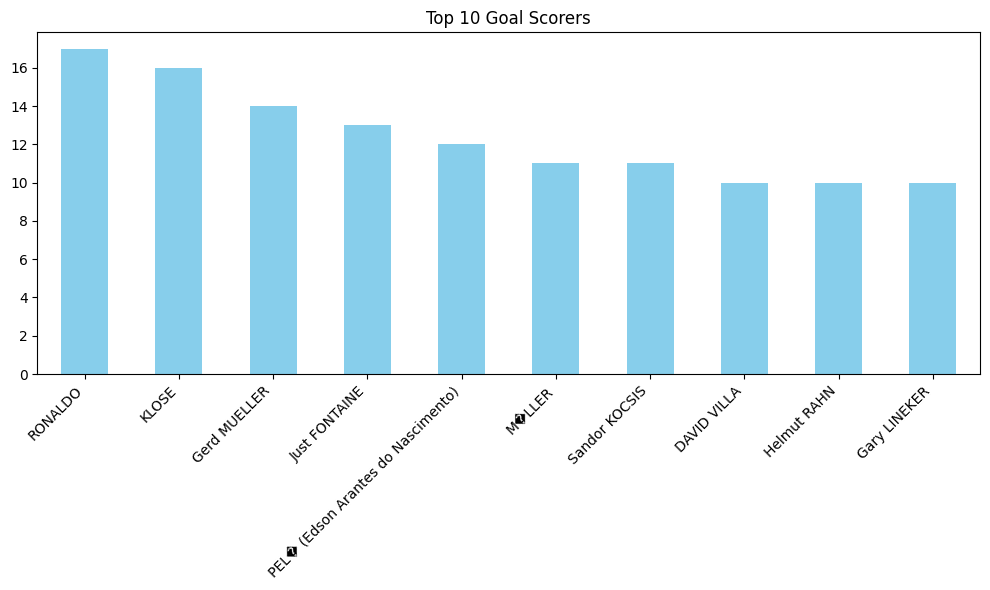

In [190]:
plt.figure(figsize=(10, 6))
goals_df['Player Name'].value_counts().head(10).plot(kind='bar', color='skyblue')
plt.title('Top 10 Goal Scorers')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()